# **Preparing the Modeling Matrix for SOC Analysis**

This notebook focuses on preparing the modeling matrix for **Soil Organic Carbon (SOC)** analysis based on the **LUCAS** dataset.

## **Scope of the Data Selection**
- **LUCAS Data Only** – We restrict our analysis to data from the **LUCAS Soil Survey**.
- **Topsoil Depth (0-20 cm)** – Only samples taken from the **0-20 cm depth interval** are considered.
- **Three Time Steps** – We include only locations with exactly **three recorded time points**, ensuring consistency and completeness in temporal analysis.

This preprocessing step ensures that our dataset is **clean, structured, and suitable for modeling**. 🚀


In [1]:
import sys
import pathlib
import os
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
# warnings.filterwarnings('default')
folder = '/mnt/primus/xuemeng_tmp_harbour/data/'
data_file = f'/home/xuemeng/work_xuemeng/ai4sh_data.harmo/data_v2/soil_soc.cleaned.o1_l2.pq'
df = pd.read_parquet(data_file)

df = df.loc[df['ref']=='LUCAS']
df = df.loc[df['hzn_dep'] == 10]
df = df[df.duplicated('id', keep=False)]
df = df[['id', 'nuts0', 'hzn_dep', 'time', 'lat', 'lon', 'lc_survey', 'soc']]

### convert to land cover types

In [2]:
lucas_values = [
    'B13', 'C10', 'B16', 'C23', 'C21', 'B11',
    'E20', 'C31', 'B12', 'B82', 'E10', 'A30', 'B41', 'B22', 'B31',
    'B33', 'C33', 'B18', 'E30', 'C32', 'B21', 'B55', 'B32', 'B15',
    'D10', 'B84', 'B52', 'B17', 'B53', 'C22', 'B37', 'B36', 'B74',
    'B81', 'B54', 'D20', 'B75', 'F40', 'B19', 'B35', 'B14', 'B51',
    'B71', 'H12', 'B23', 'B43', 'B34', 'G21', 'B42', 'B73', 'B72',
    'B76', 'B77', 'A22', 'B45', 'B83', 'H11', 'B44', 'F10', 'F30',
    'F20'
]
lucas_level1 = [code[0]+'00' for code in lucas_values]
lucas_code = dict(zip(lucas_values,lucas_level1))
df['lc_survey'] = df['lc_survey'].map(lucas_code)

survey_dict = {
    "A00": "artificial land",
    "B00": "cropland",
    "C00": "woodland",
    "D00": "shrubland",
    "E00": "grassland",
    "F00": "bare land & lichens/moss",
    "G00": "water areas & wetland", # water areas
    "H00": "water areas & wetland", #"wetland",
}
df['lc_survey'] = df['lc_survey'].map(survey_dict)

### overlay with covariates

In [3]:
years = df['time'].unique().tolist()
years = [int(ii) for ii in years]

base_path = [f'http://192.168.1.{gaia_id}:8333' for gaia_id in range(30,47)]
GDAL_OPTS = {'GDAL_HTTP_VERSION': '1.0', 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif'}
max_ram_mb = 500000
n_threads = 96

gsheet_key = '/home/xuemeng/work_xuemeng/gaia-319808-913d36b5fca4.json'
gsheet_url = 'https://docs.google.com/spreadsheets/d/1lNTpzdHBG5dirYj46iBDRJMk_YAV0Um2ovBc8v3dR9w/edit?gid=78425683#gid=78425683'
gsheet = GoogleSheet(gsheet_key, gsheet_url, verbose=False)
json_out_path = 'eu_time.series_catalog.json'

catalog = DataCatalog.create_catalog(catalog_def=gsheet.eu_ocd, years=years, base_path=base_path)
catalog.save_json(json_out_path)

from shapely.geometry import Point
from geopandas import gpd 
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

In [5]:
start = time.time()
space_overlay = SpaceTimeOverlay(
        col_date='time',
        points=df, #data_file,
        catalog=catalog,
        # raster_tiles='ard2_final_status.gpkg',
        verbose=True,
        n_threads=n_threads)
        # tile_id_col='TILE')
print(f"Extraction of overlay meta-data: {(time.time() - start):.2f} s")



[13:46:28] Overlay 16547 points from 2009 in 589 raster layers
[13:48:34] Scanning blocks of 589 layers
[13:48:34] Finding query pixels for 11117604574f51a6657e1a79c880997c (4 layers)
[13:48:34] Finding query pixels for 19c216e0d0d5c40dda2d85333be38eef (5 layers)
[13:48:40] Finding query pixels for 2fdd9b8bca8ffaf994f8fd4cc1482e00 (1 layers)
[13:49:19] Finding query pixels for 3450b653822b31a34fc31516788af952 (11 layers)
[13:49:21] Finding query pixels for 3bafbaefdf706bd9f2957546820622c9 (10 layers)
[13:49:21] Finding query pixels for 4311588f8ad1b173e54b2c56c2b75794 (15 layers)
[13:49:22] Finding query pixels for 74abec3b41ddc086f3d7abacb8ea5b3e (1 layers)
[13:49:22] Finding query pixels for 767166f0d0eead256de68a7ed2580dc4 (4 layers)
[13:49:28] Finding query pixels for 7cd181496f429fa03497a8de622e6a45 (6 layers)
[13:50:19] Finding query pixels for 8a2478377a7119f5849f41012d8146ec (139 layers)
[13:50:39] Finding query pixels for 8a9008d12d74c4106e26e9ed22377cb2 (1 layers)
[13:50:45] 

In [ ]:
start = time.time()
ovelayed_data = space_overlay.run(gdal_opts=GDAL_OPTS, max_ram_mb=max_ram_mb, out_file_name="ovelayed_year.pq")
print(f"Reading overlayed layers: {(time.time() - start)/60:.2f} mins")

[14:09:53] Running the overlay for 2009


OMP: Warning #96: Cannot form a team with 96 threads, using 72 instead.
OMP: Hint Consider unsetting KMP_DEVICE_THREAD_LIMIT (KMP_ALL_THREADS), KMP_TEAMS_THREAD_LIMIT, and OMP_THREAD_LIMIT (if any are set).


In [ ]:
# ovelayed_data.to_parquet('test.pq')
ovelayed_data.to_parquet(f'data_01_overlayed.pq')

### organize into time series

In [ ]:
df = pd.read_parquet(f'data_01_overlayed.pq')

In [ ]:
# faster way, use function from panda
filtered_ids = df['id'].value_counts() # count number of each id
filtered_ids = filtered_ids[filtered_ids == 3].index  # get ids with 3 steps in the time series
df = df[df['id'].isin(filtered_ids)] # only extract time series for points with 3 time steps

tdf = (
    df.groupby('id')
    .agg({'nuts0': 'first', 'hzn_dep': 'first', 'time': list, 'lat': list, 'lon': list, 'lc_survey': list, 'soc': list})
    .reset_index()
)

tdf.to_parquet(f'data_02_time.series.pq')
# # craft way
# tdf = pd.DataFrame(columns=['id', 'nuts0', 'hzn_dep', 'time', 'lat', 'lon', 'lc_survey', 'soc'])
# df = df.sort_values(by='time')

# for iid in df['id'].unique():
#     temp = df.loc[df['id']==iid]
#     if len(temp)==3:
#         temp_list = [iid, temp['nuts0'].values[0], temp['hzn_dep'].values[0]]
#         for icol in ['time', 'lat', 'lon', 'lc_survey', 'soc']:
#             temp_list.append(temp[icol].values.tolist())
        
#         tdf.loc[len(tdf)] = temp_list

### store the data

In [52]:
tdf = pd.parquet(f'002_data_time.series.pq')

,id,nuts0,hzn_dep,time,lat,lon,lc_survey,soc
0,57981484,EL,10.0,"[2009.0, 2015.0, 2018.0]","[35.01095, 35.01098, 35.01098]","[26.14024, 26.14022, 26.14021]","[shrubland, shrubland, shrubland]","[13.7, 15.8, 14.4]"
1,57241480,EL,10.0,"[2009.0, 2015.0, 2018.0]","[35.11201, 35.11201, 35.112013]","[25.34046, 25.34047, 25.340432]","[cropland, cropland, cropland]","[10.9, 14.1, 10.5]"
2,57141468,EL,10.0,"[2009.0, 2015.0, 2018.0]","[35.02298, 35.02298, 35.023012]","[25.21083, 25.21086, 25.21087]","[cropland, cropland, cropland]","[10.5, 10.0, 11.8]"
3,57121474,EL,10.0,"[2009.0, 2015.0, 2018.0]","[35.08004, 35.08005, 35.080052]","[25.20059, 25.2006, 25.200622]","[cropland, cropland, cropland]","[11.7, 17.6, 11.4]"
4,57081488,EL,10.0,"[2009.0, 2015.0, 2018.0]","[35.21194, 35.21198, 35.211961]","[25.18383, 25.18385, 25.183811]","[cropland, cropland, cropland]","[26.8, 25.9, 20.3]"
...,...,...,...,...,...,...,...,...
13332,57622520,RO,10.0,"[2012.0, 2015.0, 2018.0]","[44.202, 44.20199, 44.20200716880345]","[28.1921, 28.19209, 28.19209946864324]","[grassland, grassland, grassland]","[31.4, 36.5, 35.5]"
13333,53582520,RO,10.0,"[2012.0, 2015.0, 2018.0]","[44.96347, 44.96344, 44.96346603]","[23.199, 23.19897, 23.19902012]","[cropland, grassland, cropland]","[65.8, 86.4, 140.2]"
13334,57482568,RO,10.0,"[2012.0, 2015.0, 2018.0]","[44.6508, 44.65079, 44.65076670655149]","[28.1583, 28.15835, 28.158340201236356]","[cropland, cropland, cropland]","[15.0, 18.1, 20.9]"
13335,57962548,RO,10.0,"[2012.0, 2015.0, 2018.0]","[44.37072, 44.37071, 44.3707230719974]","[28.68857, 28.6885, 28.68858406207422]","[cropland, bare land & lichens/moss, cropland]","[14.3, 15.4, 17.7]"


In [36]:
m = df['id'].value_counts()==3

In [11]:
import pandas as pd

# Define target columns
tdf_cols = ['id', 'time', 'lat', 'lon', 'nuts0', 'hzn_dep', 'lc_survey', 'soc']

# Sort by time
df = df.sort_values(by='time')

# Filter IDs that have exactly 3 occurrences
filtered_ids = df['id'].value_counts()
filtered_ids = filtered_ids[filtered_ids == 3].index

# Keep only relevant IDs
df_filtered = 

# Group by 'id' and store values as lists
tdf = df_filtered

# Display the result
import ace_tools as tools
tools.display_dataframe_to_user(name="Processed Data", dataframe=tdf)


,time,lat,lon,id,ref,nuts0,hzn_dep,lc_survey,soc_qa,soc
41174,2009.0,35.010950,26.140240,57981484,LUCAS,EL,10.0,shrubland,5.0,13.7
54625,2009.0,45.973730,3.818960,38422560,LUCAS,FR,10.0,NaN,5.0,147.5
54626,2009.0,45.865920,3.831400,38422548,LUCAS,FR,10.0,cropland,5.0,18.1
54627,2009.0,50.397636,3.224466,38403054,LUCAS,FR,10.0,cropland,5.0,29.8
54628,2009.0,50.200844,3.252646,38403032,LUCAS,FR,10.0,cropland,5.0,43.0
...,...,...,...,...,...,...,...,...,...,...
91044,2018.0,40.411746,-2.526745,32582012,LUCAS,ES,10.0,cropland,5.0,9.8
91045,2018.0,40.892717,-2.623471,32582066,LUCAS,ES,10.0,shrubland,5.0,73.0
91046,2018.0,40.963938,-2.637967,32582074,LUCAS,ES,10.0,shrubland,5.0,36.6
91031,2018.0,39.621204,-2.419298,32541924,LUCAS,ES,10.0,cropland,5.0,7.0


In [4]:
df['lc_survey'].unique()

array(['shrubland', 'cropland', nan, 'grassland', 'woodland',
       'artificial land', 'water areas & wetland',
       'bare land & lichens/moss'], dtype=object)

<Axes: >

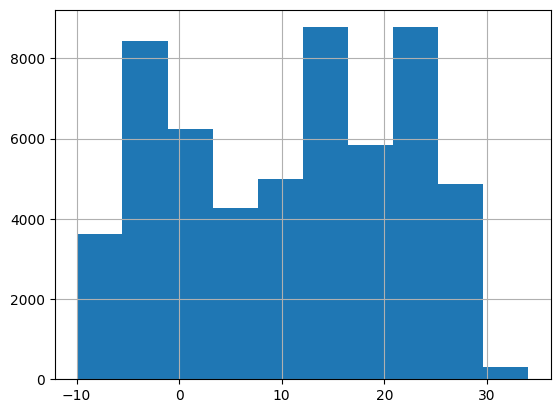

In [2]:
df['lon'].hist()

In [4]:

df.loc[df['lon']<-10]

,id,nuts0,hzn_dep,time,lat,lon,lc_survey,soc
